In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel

fmri_dataset = 'data/dataset/dataset_all_subjects_LEiDA.hdf5'

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

# Modeling on BOLD

## Mixture modelling - Watson

<IPython.core.display.Javascript object>


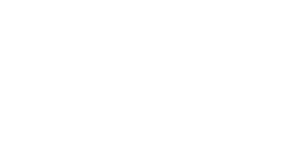

pi
tensor([0.2908, 0.3936, 0.3156])
------------------------------
mix_comp_0
tensor([[1.0466, 0.5653, 0.8311],
        [0.5653, 1.6652, 0.7813],
        [0.8311, 0.7813, 1.3307]])
------------------------------
mix_comp_1
tensor([[ 1.3469,  0.4943, -0.6388],
        [ 0.4943,  0.8798, -0.6412],
        [-0.6388, -0.6412,  1.3786]])
------------------------------
mix_comp_2
tensor([[0.7697, 0.0230, 0.4334],
        [0.0230, 0.8555, 0.3897],
        [0.4334, 0.3897, 1.5039]])
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:37<00:00, 16.13it/s]

pi
tensor([0.2580, 0.5045, 0.2375])
------------------------------
mix_comp_0
tensor([[ 0.7214,  0.3747,  1.6912],
        [ 0.3747,  1.1851,  2.9108],
        [ 1.6912,  2.9108, 13.2573]])
------------------------------
mix_comp_1
tensor([[ 1.1740e+02, -4.3379e+00,  2.1947e+00],
        [-4.3379e+00,  2.8346e-01, -8.1463e-02],
        [ 2.1947e+00, -8.1463e-02,  1.5977e-01]])
------------------------------
mix_comp_2
tensor([[ 6.9129e-02, -1.7117e-04, -2.7699e-03],
        [-1.7117e-04,  1.3067e+01,  3.0090e+01],
        [-2.7699e-03,  3.0090e+01,  1.4595e+02]])
------------------------------


<IPython.core.display.Javascript object>


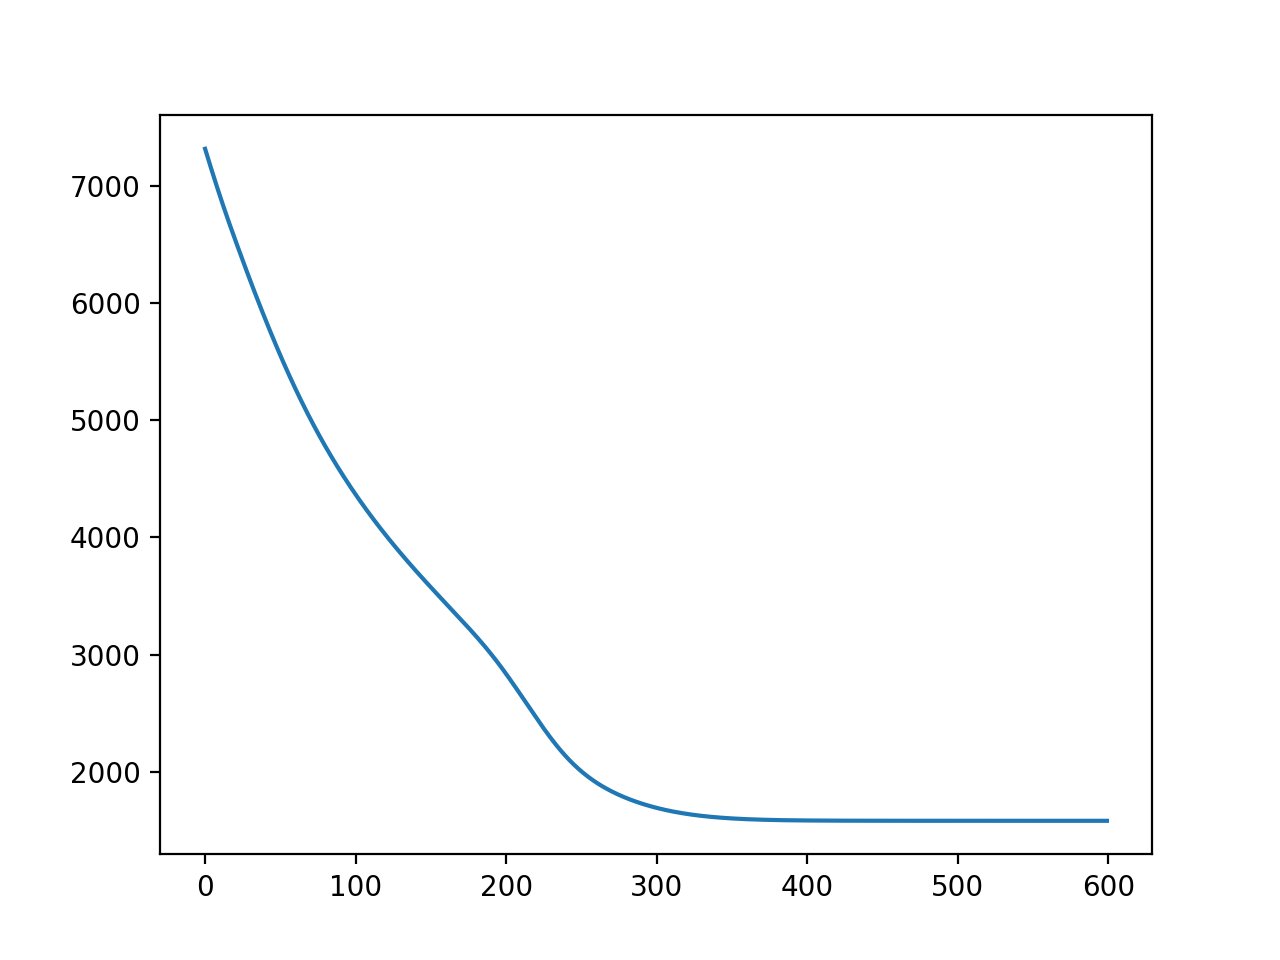

Min LL: -1582.094970703125


In [110]:
plt.clf()
%matplotlib notebook
model_dist = ACG
model = TorchMixtureModel(model_dist, K=3, dist_dim=3)

_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.01)

epoch_likelihood = train_mixture(model, data=X, optimizer=Adam_optimizer, num_epoch=600)

_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()
print(f'Min LL: {-epoch_likelihood[-1]}')

### Fitting paramerter results

In [111]:
param = get_param(model)

pi
tensor([0.2580, 0.5045, 0.2375])
------------------------------
mix_comp_0
tensor([[ 0.7214,  0.3747,  1.6912],
        [ 0.3747,  1.1851,  2.9108],
        [ 1.6912,  2.9108, 13.2573]])
------------------------------
mix_comp_1
tensor([[ 1.1740e+02, -4.3379e+00,  2.1947e+00],
        [-4.3379e+00,  2.8346e-01, -8.1463e-02],
        [ 2.1947e+00, -8.1463e-02,  1.5977e-01]])
------------------------------
mix_comp_2
tensor([[ 6.9129e-02, -1.7117e-04, -2.7699e-03],
        [-1.7117e-04,  1.3067e+01,  3.0090e+01],
        [-2.7699e-03,  3.0090e+01,  1.4595e+02]])
------------------------------


In [112]:
## Synthectic as np array
synX, syn_cluster_id = np.array(X), np.array(cluster_id)

## Plot of Synthetic | Learned Mixture Clusters from Parameters | Watson $\mu$ directions

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


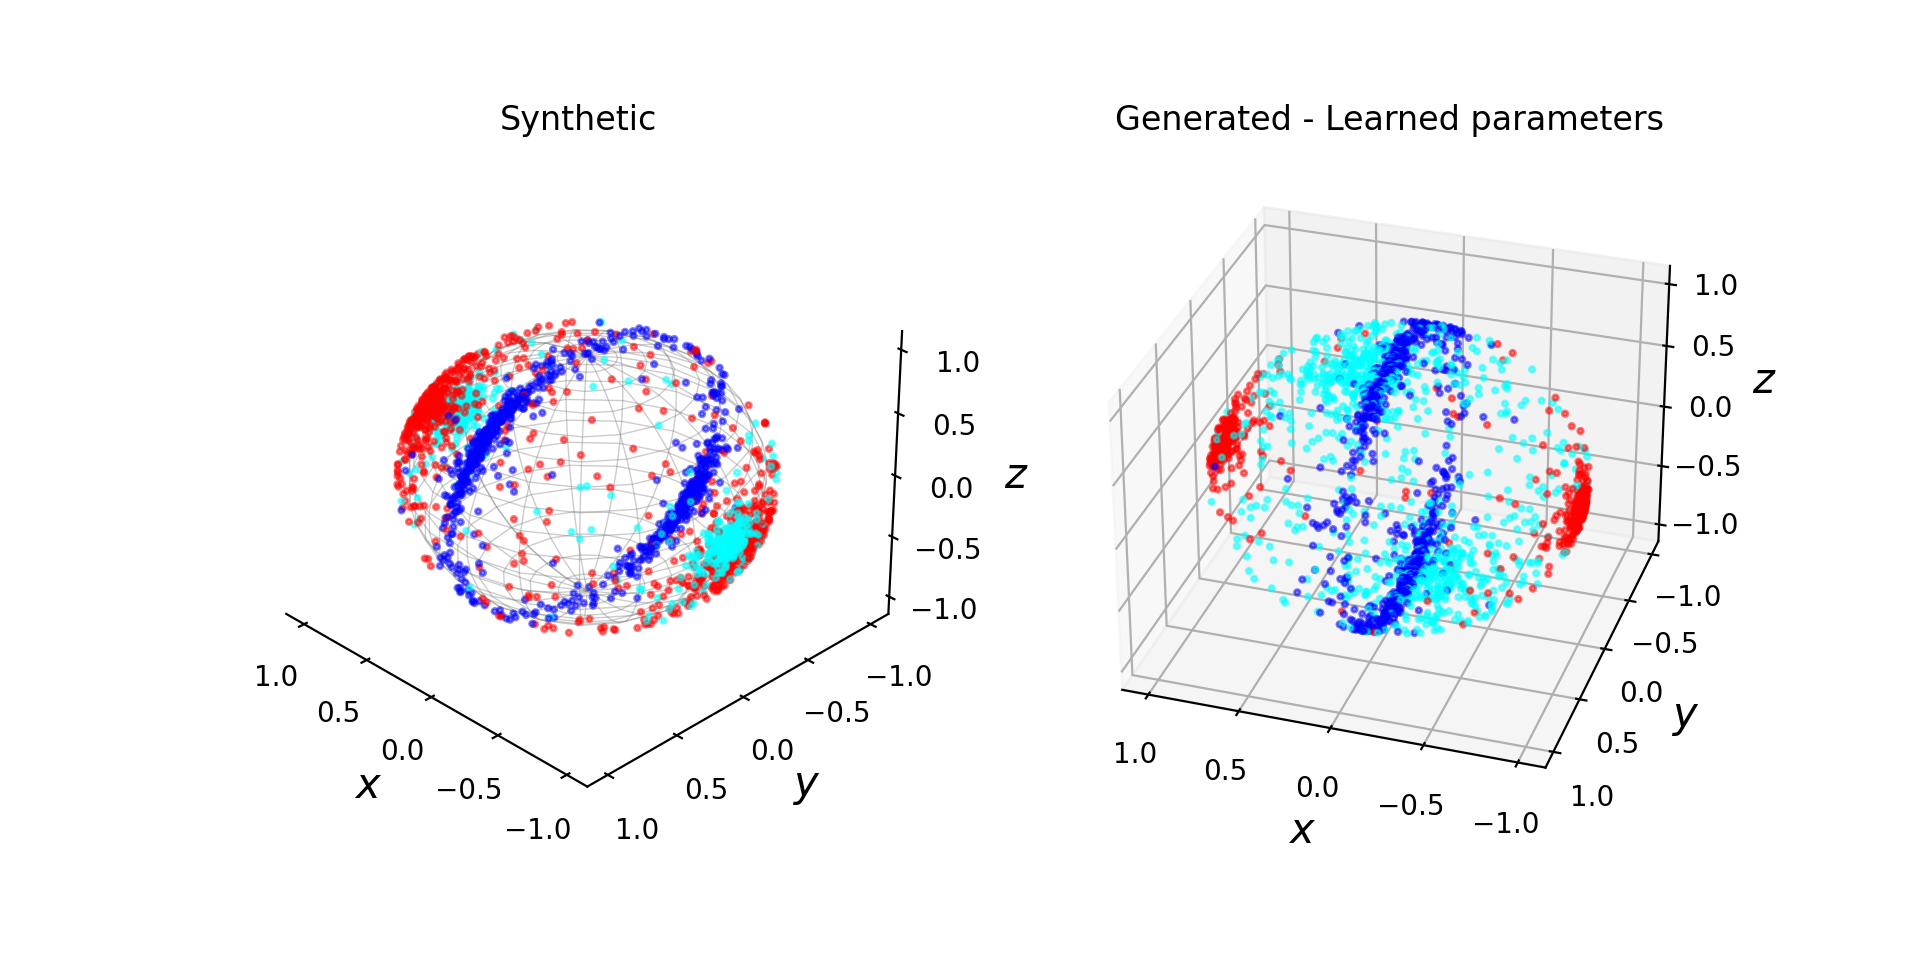

In [115]:
if model_dist == ACG:
    learned_sigma = torch.stack([param[f'mix_comp_{idx}'] for idx in range(model.K)])
    learned_pi = param['pi']
    LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)
    
    fig = plt.figure(figsize=plt.figaspect(0.5))
    id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

    # Synthetic
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Synthetic')
    #Background
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)

    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)

    x = .95 * np.outer(np.cos(u), np.sin(v))
    y = .95 * np.outer(np.sin(u), np.sin(v))
    z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
    ax.view_init(30, 135)

    # Learned
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    label_color = [id_2_color[id] for id in Learn_cluster_id]
    ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Generated - Learned parameters')
    ax.view_init(30, 135)
    plt.show()


elif model_dist == Watson:
    Watson_comps = [param[f'mix_comp_{idx}'] for idx in range(model.K)]
    learned_pi = param['pi']
    
    
    fig = plt.figure(figsize=(10,10))
    id_2_color = {0: 'yellow', 1: 'red', 2: 'blue'}

#     # Synthetic
#     ax = fig.add_subplot(1, 2, 1, projection='3d')
#     label_color = [id_2_color[id] for id in syn_cluster_id]
#     ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
#     ax.set_xlabel('$x$', fontsize=15)
#     ax.set_ylabel('$y$', fontsize=15)
#     ax.set_zlabel('$z$', fontsize=15)
#     ax.set_title('Synthetic')
    #Background
#     ax.xaxis.pane.fill = False
#     ax.yaxis.pane.fill = False
#     ax.zaxis.pane.fill = False
#     ax.xaxis.pane.set_edgecolor('w')
#     ax.yaxis.pane.set_edgecolor('w')
#     ax.zaxis.pane.set_edgecolor('w')
#     ax.grid(False)

#     u = np.linspace(0, 2 * np.pi, 20)
#     v = np.linspace(0, np.pi, 20)

#     x = .95 * np.outer(np.cos(u), np.sin(v))
#     y = .95 * np.outer(np.sin(u), np.sin(v))
#     z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
#     ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
#     ax.view_init(30, 135)

    # Synthetic with Mean direction from watson
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    label_color = [id_2_color[id] for id in syn_cluster_id]
    ax.scatter(synX[:, 0], synX[:, 1], synX[:, 2], s=4, alpha=0.5, c=label_color)
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_zlabel('$z$', fontsize=15)
    ax.set_title('Learned Watson directions')
    # Watson Mu
    for w_param in Watson_comps:
        mu_vec = np.array(w_param['mu'])
        kappa_p = w_param['kappa']
        ax.quiver(0, 0, 0, *mu_vec, color = 'g')
    ax.view_init(30, 135)
    plt.show()
    

# Hidden Markov Model - Synthetic data

In [153]:
%matplotlib notebook
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
from utils.training import train_hmm_subjects
import scipy

Simulate sequence of length 150 from 3 hidden states


<IPython.core.display.Javascript object>


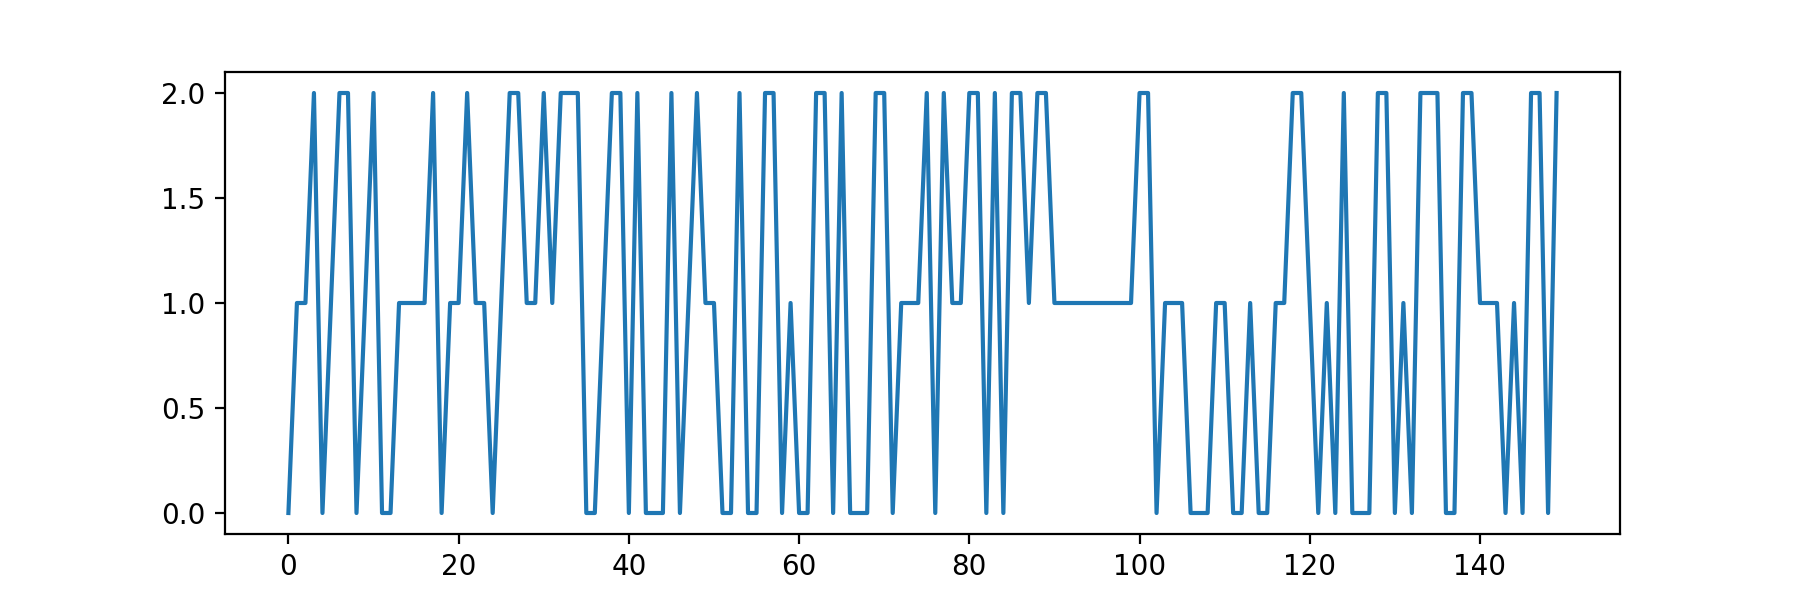

In [141]:
TRANSITION = torch.tensor([[0.4, 0.4, 0.2],
                          [0.2, 0.6, 0.2],
                          [0.4, 0.3, 0.3]])
PIs = [0.6, 0.2, 0.2]
X_emission, Z_seq = syntheticHMM(pi=PIs, Sigmas=SIGMAs, transition_matrix=TRANSITION, seq_len=150, num_subject = 20)

fig = plt.figure(figsize=(9,3))
ax = fig.add_subplot(1,1,1)
ax.plot(Z_seq[0])
plt.show()

### Training HMM on synthetic data

In [143]:
model_dist = ACG
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

un_norm_priors
tensor([0.2651, 0.1716, 0.0652])
------------------------------
un_norm_Transition_matrix
tensor([[0.3203, 0.1152, 0.2269],
        [0.1827, 0.1439, 0.0010],
        [0.2966, 0.2833, 0.2073]])
------------------------------
emission_model_0
tensor([[ 0.8391,  0.9286, -0.2463],
        [ 0.9286,  2.9540, -0.0396],
        [-0.2463, -0.0396,  2.0037]])
------------------------------
emission_model_1
tensor([[ 1.3059, -0.7702, -0.8090],
        [-0.7702,  1.6604,  1.3476],
        [-0.8090,  1.3476,  2.3606]])
------------------------------
emission_model_2
tensor([[ 1.5716,  0.1111, -1.0137],
        [ 0.1111,  0.5946,  0.6348],
        [-1.0137,  0.6348,  2.6176]])
------------------------------


100%|██████████████████████████████████████████████| 200/200 [00:55<00:00,  3.58it/s]

un_norm_priors
tensor([-0.1410, -0.8464,  0.6835])
------------------------------
un_norm_Transition_matrix
tensor([[ 0.1303,  0.0866,  0.1012],
        [-0.2512,  0.2345, -0.2658],
        [ 0.0728,  0.2219,  0.1092]])
------------------------------
emission_model_0
tensor([[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
        [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
        [-2.0065e-03,  3.1824e+01,  1.3920e+02]])
------------------------------
emission_model_1
tensor([[ 0.5939,  0.3365,  1.3631],
        [ 0.3365,  0.9666,  2.3316],
        [ 1.3631,  2.3316, 10.2959]])
------------------------------
emission_model_2
tensor([[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
        [-1.0077e+00,  1.1578e-01, -8.0832e-02],
        [ 9.0111e+00, -8.0832e-02,  8.8190e-01]])
------------------------------


<IPython.core.display.Javascript object>


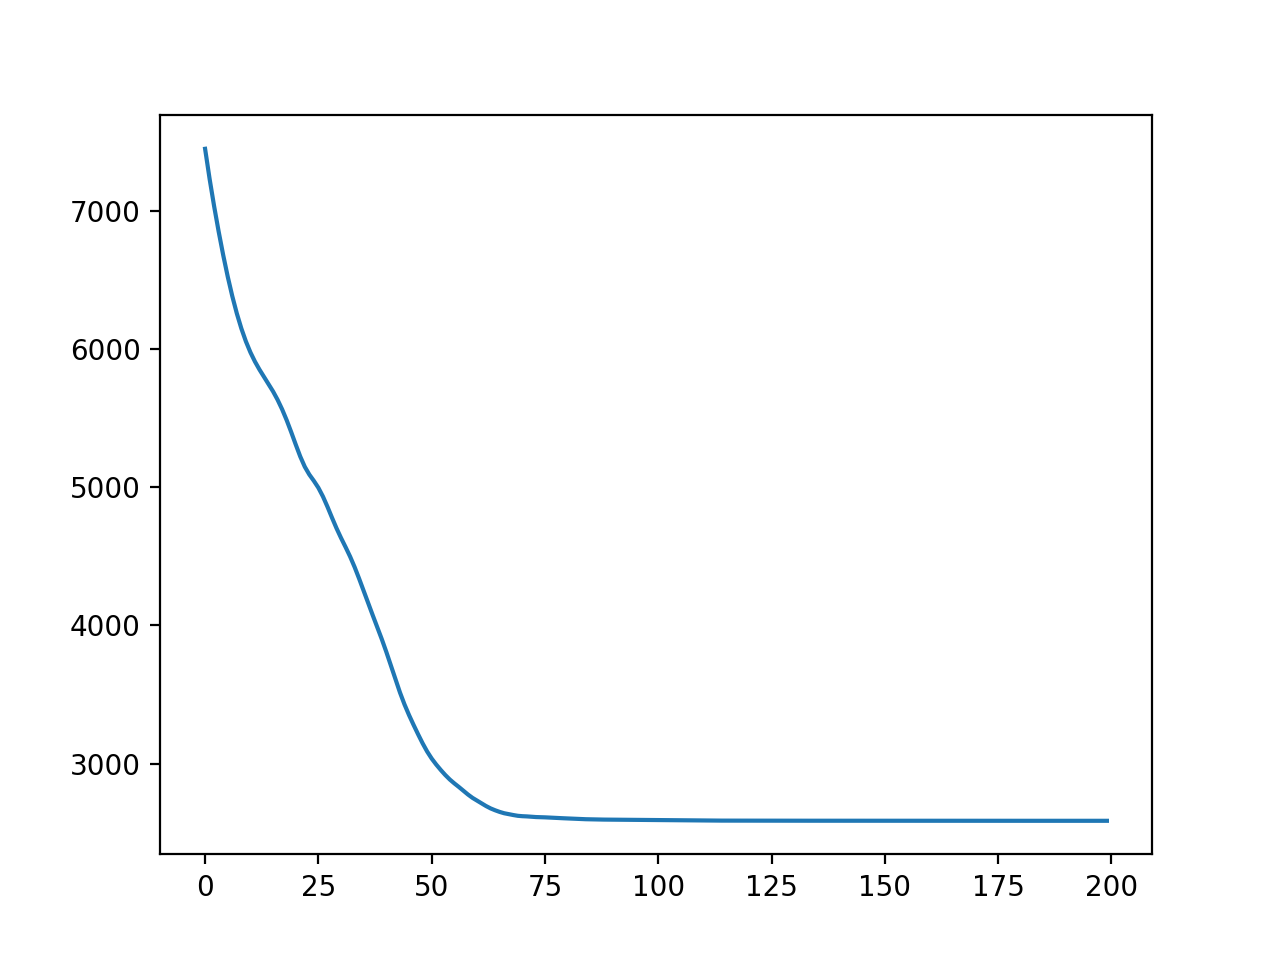

Max LL: -2585.237548828125
un_norm_priors
tensor([-0.1410, -0.8464,  0.6835])
------------------------------
un_norm_Transition_matrix
tensor([[ 0.1303,  0.0866,  0.1012],
        [-0.2512,  0.2345, -0.2658],
        [ 0.0728,  0.2219,  0.1092]])
------------------------------
emission_model_0
tensor([[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
        [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
        [-2.0065e-03,  3.1824e+01,  1.3920e+02]])
------------------------------
emission_model_1
tensor([[ 0.5939,  0.3365,  1.3631],
        [ 0.3365,  0.9666,  2.3316],
        [ 1.3631,  2.3316, 10.2959]])
------------------------------
emission_model_2
tensor([[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
        [-1.0077e+00,  1.1578e-01, -8.0832e-02],
        [ 9.0111e+00, -8.0832e-02,  8.8190e-01]])
------------------------------


In [144]:
# add batch dim for HMM to X
Adam_optimizer = optim.Adam(model.parameters(), lr=0.04)
epoch_likelihood = train_hmm(model, data=X_emission, optimizer=Adam_optimizer, num_epoch=200)

_ = get_param(model)

plt.clf()
%matplotlib notebook
plt.plot(epoch_likelihood)
plt.show()
print(f'Max LL: {-epoch_likelihood[-1]}')
_ = get_param(model)

In [381]:
param = get_param(model)

un_norm_priors
tensor([-0.1410, -0.8464,  0.6835])
------------------------------
un_norm_Transition_matrix
tensor([[ 0.1303,  0.0866,  0.1012],
        [-0.2512,  0.2345, -0.2658],
        [ 0.0728,  0.2219,  0.1092]])
------------------------------
emission_model_0
tensor([[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
        [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
        [-2.0065e-03,  3.1824e+01,  1.3920e+02]])
------------------------------
emission_model_1
tensor([[ 0.5939,  0.3365,  1.3631],
        [ 0.3365,  0.9666,  2.3316],
        [ 1.3631,  2.3316, 10.2959]])
------------------------------
emission_model_2
tensor([[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
        [-1.0077e+00,  1.1578e-01, -8.0832e-02],
        [ 9.0111e+00, -8.0832e-02,  8.8190e-01]])
------------------------------


In [154]:
learned_sigma = torch.stack([param[f'emission_model_{idx}'] for idx in range(model.N)])
learned_pi = param['un_norm_priors']
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(learned_pi)

[0.26492825 0.13084714 0.6042246 ]


Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


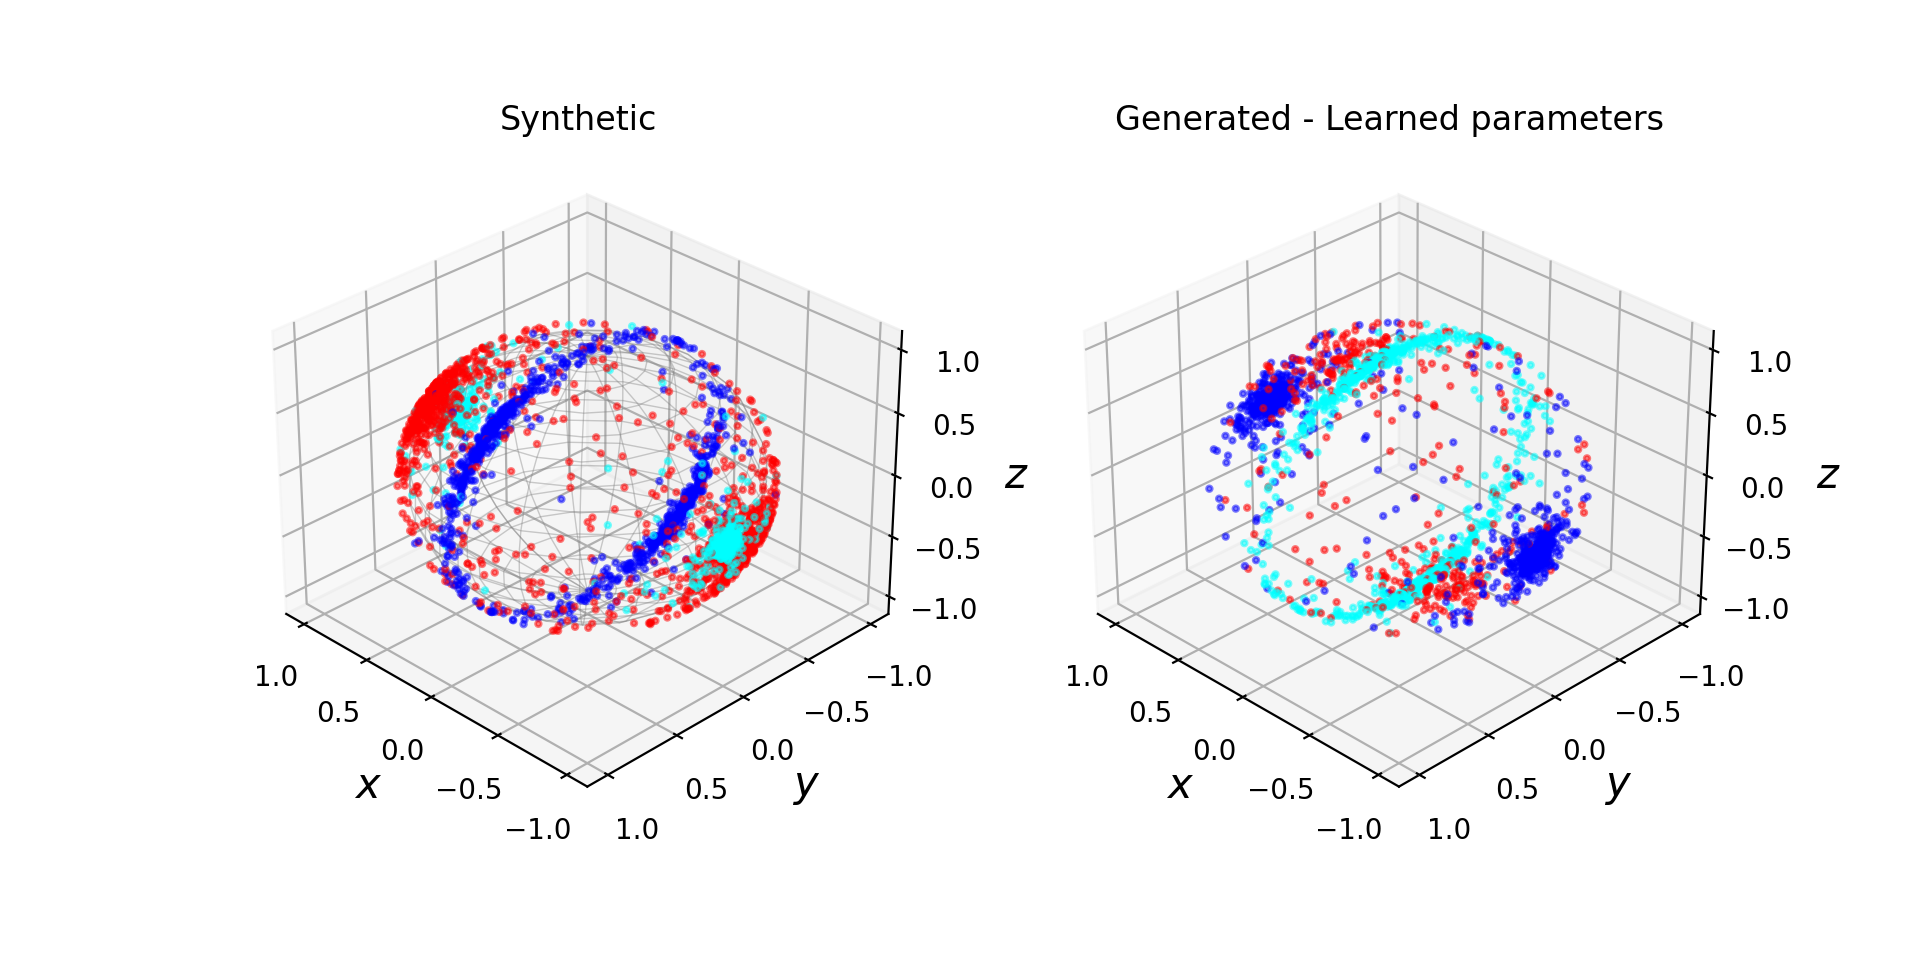

In [382]:
# softmax in syn generation
LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Synthetic GT (concate from batches of HMM synthetic)
X_gt_plot = torch.cat(tuple([*X_emission]),0)
Z_seq_plot = torch.cat(tuple([*Z_seq]),0)

ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[int(id)] for id in Z_seq_plot]
ax.scatter(X_gt_plot[:, 0], X_gt_plot[:, 1], X_gt_plot[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')


u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.view_init(30, 135)
plt.show()

In [391]:
paths, paths_probs = model.viterbi2(X_emission)

<IPython.core.display.Javascript object>


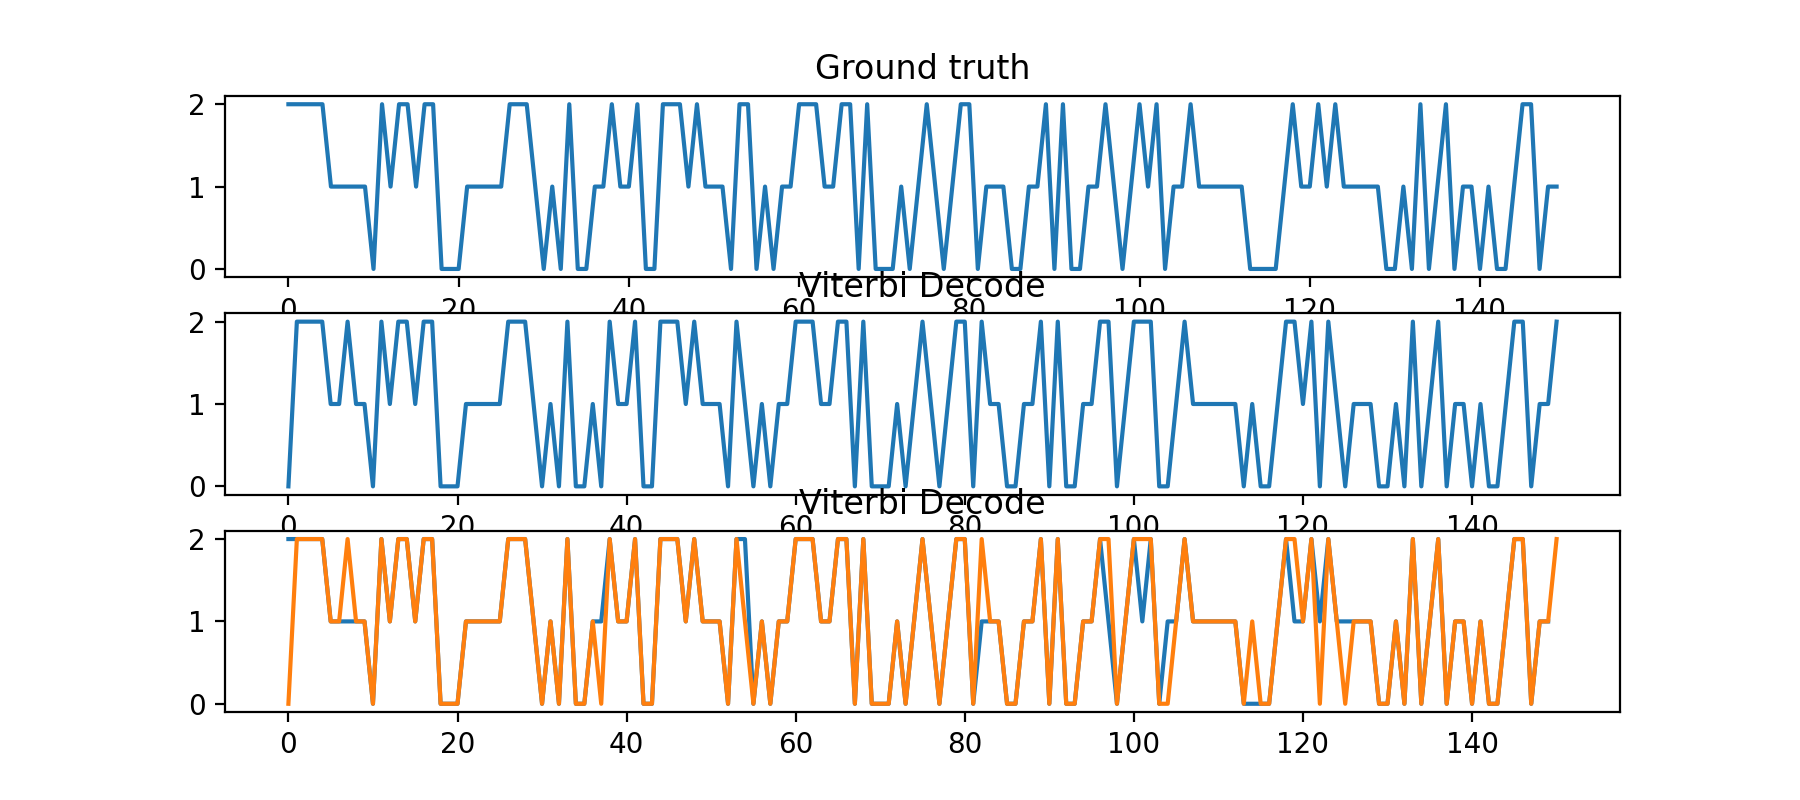

In [392]:
pp = paths[4]

d = {'0':2,'2':0}
pp = [Z if Z == 1 else d[str(Z)] for Z in pp]
pp.insert(0,0)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(3,1,1)
ax.set_title('Ground truth')
ax.plot(Z_seq[4])

ax = fig.add_subplot(3,1,2)
ax.plot(pp)
ax.set_title('Viterbi Decode')

ax = fig.add_subplot(3,1,3)
ax.plot(np.array(Z_seq[4]))
ax.plot(pp)
ax.set_title('Viterbi Decode')

plt.show()

# Viterbi Check with clone

### State mapping 

In [ ]:
# 0 cyan -> blue (2)
# 1 red -> red (1)
# 2 blue -> cyan(0)

# 0 -> 2
# 1 -> 1
# 2 -> 0

In [198]:
seq, prob = model.viterbi(X_emission)
print(seq[0])

tensor([[-17.9842,  -8.1262,  -3.4060],
        [ -6.0340,  -8.2784, -13.2517],
        [-19.6604, -10.4687,   0.8940],
        [-18.0112,  -4.5324,  -9.8509],
        [ -4.1476,  -9.7032, -13.4533],
        [ -9.0800,  -9.2217,  -4.2878],
        [-15.2546,  -8.7275,  -6.7781],
        [-19.7658, -10.0439,   6.0938],
        [-13.8443, -11.0043, -13.0444],
        [-19.2043,  -8.1468,  -4.3449],
        [-18.8679,  -9.7994,  -6.1719],
        [-11.8357,  -9.4951, -11.7030],
        [-18.2737,  -6.1931,  -2.5920],
        [-11.2511,  -9.6484,  -7.8317],
        [-19.7618,  -9.9133,   4.6200],
        [-17.8135,  -6.7276,  -5.0974],
        [-12.6580, -10.6412,  -3.7279],
        [  2.2430,  -8.1778, -13.3163],
        [ -5.4477,  -8.9163, -13.3502],
        [-19.7579, -10.1728,   4.0686]], grad_fn=<MaxBackward0>)
tensor([[-26.6871,  -9.0716,  -9.2899],
        [-15.7908, -12.7044,  -9.9741],
        [-18.6471, -13.9661,  -6.0180],
        [-27.6101,  -8.6345, -13.4420],
        [ -2.82

tensor([[-587.4482, -328.9915, -449.3682],
        [-571.9944, -357.8231, -427.9275],
        [-621.7134, -335.2703, -416.8853],
        [-610.0110, -333.0246, -471.5958],
        [-550.2216, -334.7655, -446.7436],
        [-614.7280, -354.6823, -338.6452],
        [-554.1705, -335.9559, -468.3114],
        [-624.0741, -340.5427, -425.7784],
        [-655.6614, -343.3450, -384.7222],
        [-588.2267, -333.6147, -414.7456],
        [-637.7292, -360.3190, -360.8164],
        [-656.5120, -349.0400, -398.4779],
        [-652.9289, -320.4958, -402.3886],
        [-560.2823, -349.4263, -481.0915],
        [-640.0175, -348.3220, -374.9119],
        [-597.1561, -325.3609, -497.7302],
        [-495.6806, -341.3612, -450.5104],
        [-553.6458, -306.6271, -490.7043],
        [-575.1136, -341.5354, -410.6773],
        [-634.8261, -315.8819, -470.7615]], grad_fn=<MaxBackward0>)
tensor([[-595.7319, -329.6194, -455.5754],
        [-570.8707, -361.3154, -434.8400],
        [-623.4128, -338.9679

In [158]:
import copy

In [159]:
test_model = copy.deepcopy(model)

In [202]:
test_model.emission_models_forward(X_emission[:,0,:])[:,0]

tensor([-8.6813, -3.6679,  3.5139], grad_fn=<SelectBackward0>)

In [207]:
test_model.emission_models[1](X_emission[0,0].unsqueeze(dim=0))

tensor([-3.6679], grad_fn=<SubBackward0>)

In [379]:
ld = test_model.viterbi2(X_emission)
d = {'0':2,'2':0}
ld = [Z if Z == 1 else d[str(Z)] for Z in ld]
ld.insert(0,0)

<IPython.core.display.Javascript object>


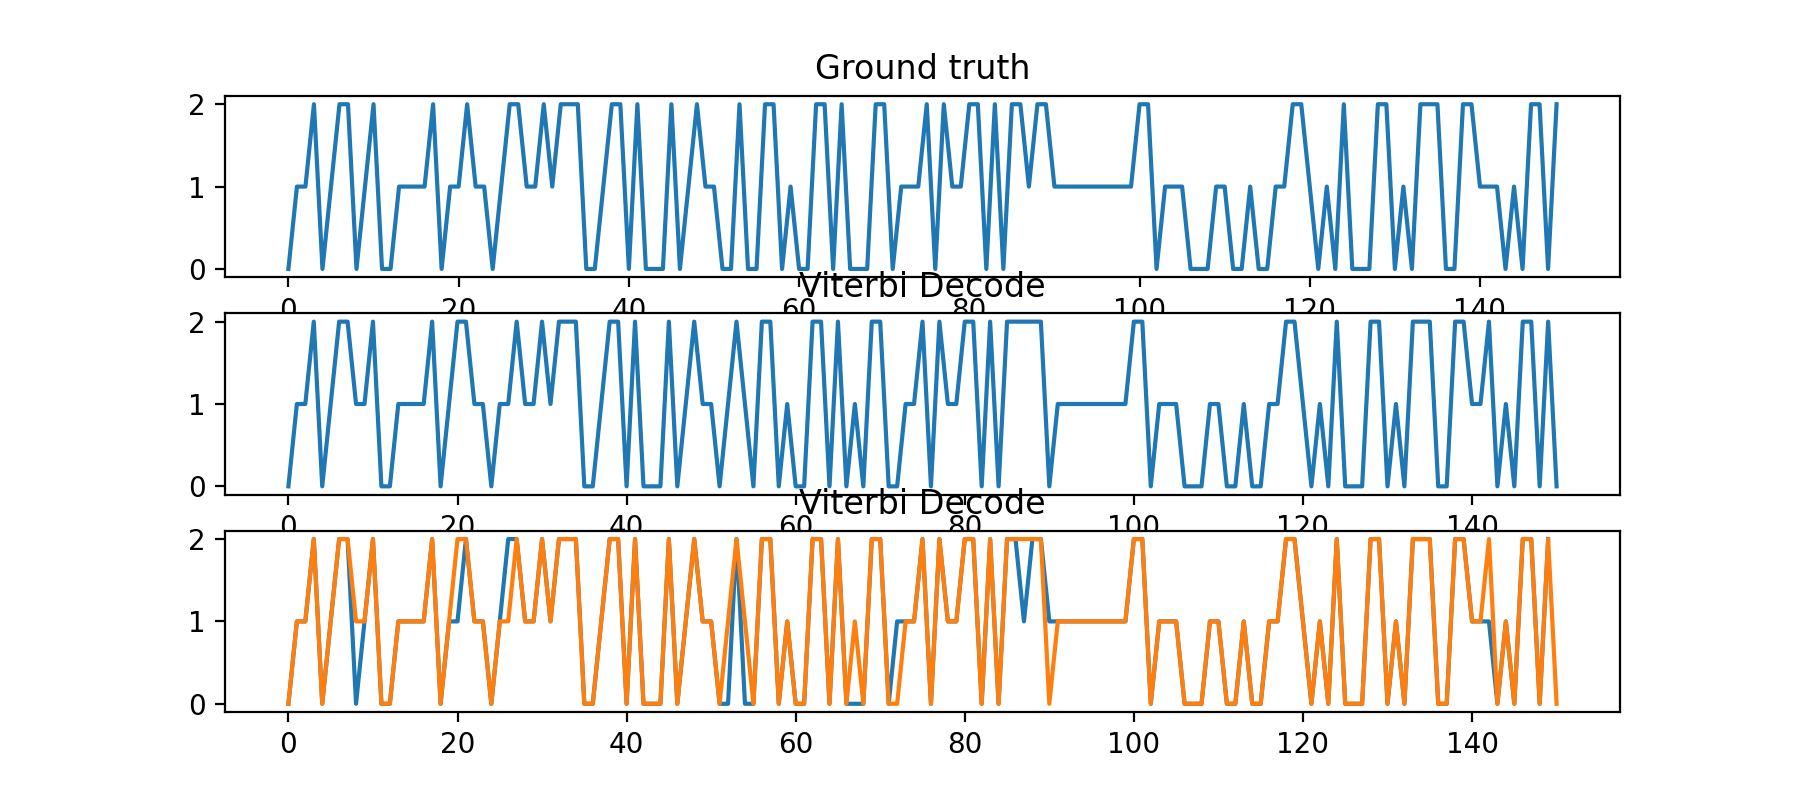

In [380]:
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(3,1,1)
ax.set_title('Ground truth')
ax.plot(Z_seq[0])

ax = fig.add_subplot(3,1,2)
ax.plot(ld)
ax.set_title('Viterbi Decode')

ax = fig.add_subplot(3,1,3)
ax.plot(np.array(Z_seq[0]))
ax.plot(ld)
ax.set_title('Viterbi Decode')

plt.show()

In [370]:
np.array(Z_seq[0]) - ld

array([-1,  0, -1,  2, -1, -1,  0,  1, -1, -1,  2,  0, -1,  0,  0,  0, -1,
        2, -1, -1, -1,  1,  0,  1, -1,  0,  0,  1,  0, -1,  1, -1,  0,  0,
        2,  0, -1, -1,  0,  2, -2,  2,  0,  0, -2,  2, -1, -1,  1,  0,  1,
       -1, -2,  1,  0, -2,  0,  2, -1,  1,  0, -2,  0,  2, -2,  2, -1,  0,
       -2,  0,  2,  0,  0,  0, -1,  2, -2,  1,  0, -1,  0,  2, -2,  2, -2,
        0,  0, -1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  2,
       -1,  0,  0,  1,  0,  0, -1,  0,  1,  0, -1,  1,  0, -1,  0, -1,  0,
        1,  1, -1,  1, -2,  2,  0,  0, -2,  0,  2, -1,  1, -2,  0,  0,  2,
        0, -2,  0,  1,  0, -1,  1, -1,  1, -2,  0,  2, -2,  2])

In [352]:
list(range(10 - 2, -1, -1))

[8, 7, 6, 5, 4, 3, 2, 1, 0]

In [161]:
test_model.transition_matrix.data.softmax(dim=1)

tensor([[0.3415, 0.3269, 0.3317],
        [0.2769, 0.4501, 0.2729],
        [0.3127, 0.3630, 0.3243]])

In [163]:
test_Transition = torch.tensor([[0.2, 0.4, 0.4],
                          [0.2, 0.6, 0.2],
                          [0.3, 0.3, 0.4]])

In [189]:
test_model.transition_matrix = torch.nn.Parameter(test_Transition)
test_model.state_priors = torch.nn.Parameter(torch.tensor([0.2,0.2,0.6]))
optim_seq, optim_path_probs = model.viterbi2(X_emission, external_eval=True)
optim_seq[0]

23

In [167]:
test_param = get_param(test_model)

un_norm_priors
tensor([0.2000, 0.2000, 0.6000])
------------------------------
un_norm_Transition_matrix
tensor([[0.2000, 0.4000, 0.4000],
        [0.2000, 0.6000, 0.2000],
        [0.3000, 0.3000, 0.4000]])
------------------------------
emission_model_0
tensor([[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
        [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
        [-2.0065e-03,  3.1824e+01,  1.3920e+02]])
------------------------------
emission_model_1
tensor([[ 0.5939,  0.3365,  1.3631],
        [ 0.3365,  0.9666,  2.3316],
        [ 1.3631,  2.3316, 10.2959]])
------------------------------
emission_model_2
tensor([[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
        [-1.0077e+00,  1.1578e-01, -8.0832e-02],
        [ 9.0111e+00, -8.0832e-02,  8.8190e-01]])
------------------------------


In [181]:
test_sigma = torch.stack([param[f'emission_model_{idx}'] for idx in range(test_model.N)])

In [182]:
test_sigma

tensor([[[ 7.7739e-02,  3.1716e-03, -2.0065e-03],
         [ 3.1716e-03,  1.6838e+01,  3.1824e+01],
         [-2.0065e-03,  3.1824e+01,  1.3920e+02]],

        [[ 5.9391e-01,  3.3652e-01,  1.3631e+00],
         [ 3.3652e-01,  9.6659e-01,  2.3316e+00],
         [ 1.3631e+00,  2.3316e+00,  1.0296e+01]],

        [[ 1.0518e+02, -1.0077e+00,  9.0111e+00],
         [-1.0077e+00,  1.1578e-01, -8.0832e-02],
         [ 9.0111e+00, -8.0832e-02,  8.8190e-01]]])

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


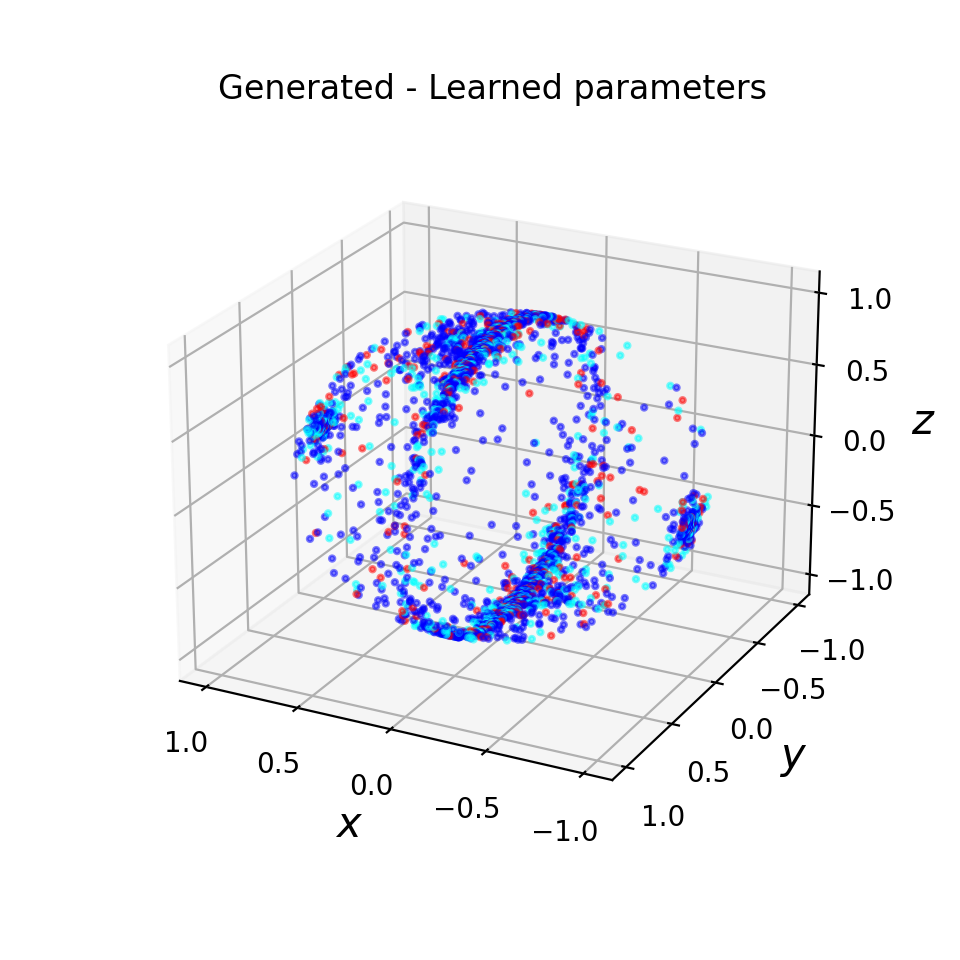

In [185]:
# softmax in syn generation

testX, test_cluster_id = syntheticMixture3D(pi=np.array([0.6,0.2,0.2]),Sigmas=test_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(1.0))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

# Learned
ax = fig.add_subplot(1, 1, 1, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(testX[:, 0], testX[:, 1], testX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.view_init(30, 135)
plt.show()

# Mixture Model on FMRI data

In [119]:
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
%matplotlib notebook
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'

### Loading data

In [120]:
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90
bold_data = torch.zeros(num_subjects,seq_len,obs_dim)

bold_mixture = torch.zeros(num_subjects*seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    bold_data[idx] = torch.tensor(np.array(dataf[subject]))
    

print(bold_data.shape)

torch.Size([199, 330, 90])


### Watson Mixture on Bold

100%|█| 100/100 [01:51<00:00,  1.12s/i


<IPython.core.display.Javascript object>


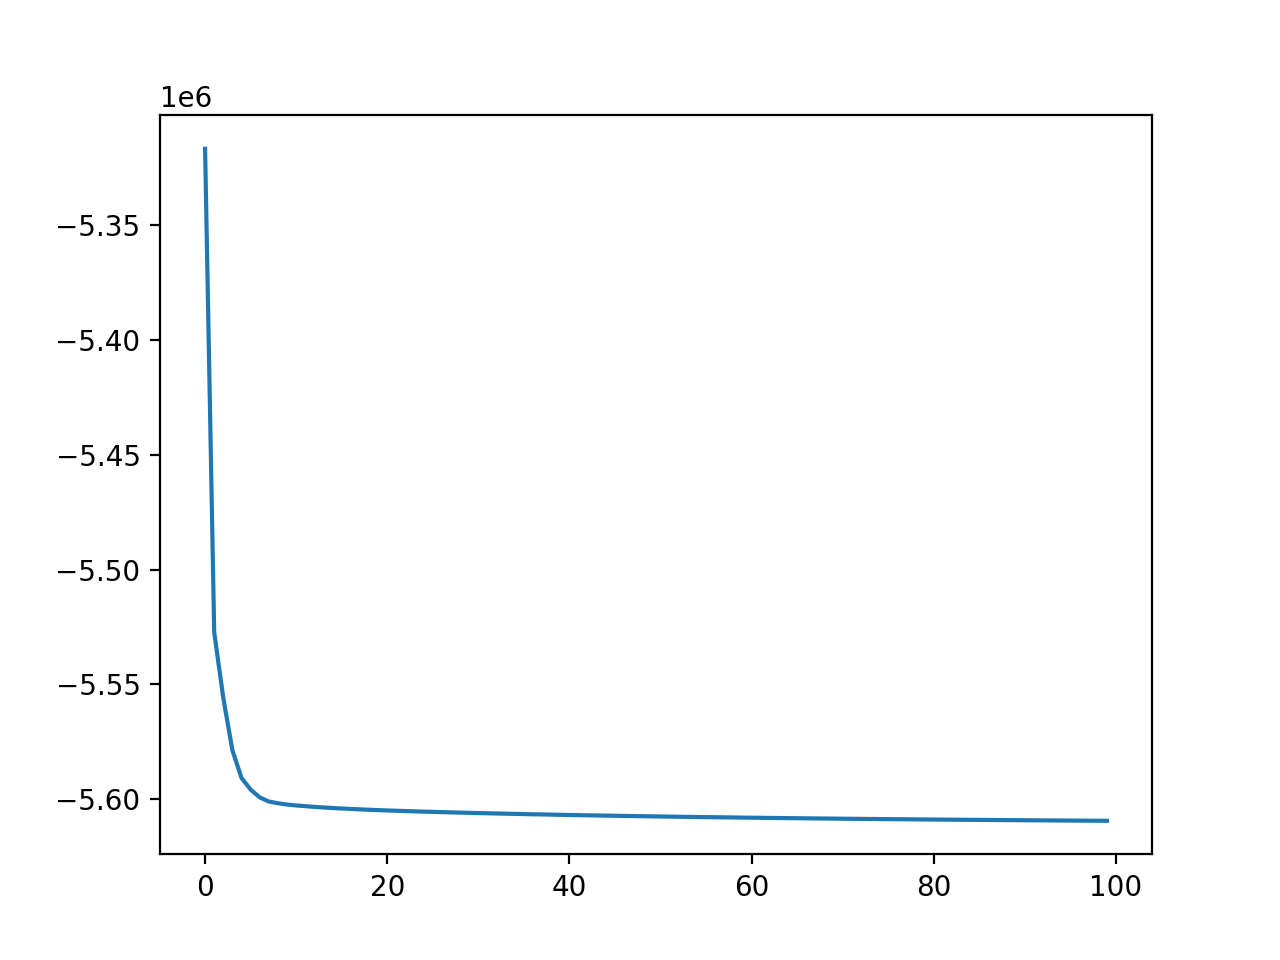

In [111]:
model_dist = Watson
model = TorchMixtureModel(model_dist, K=6, dist_dim=obs_dim)

#_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.8)

epoch_likelihood = train_mixture_subjects(model, data=bold_data, optimizer=Adam_optimizer, num_epoch=100)

#_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()

### ACG mixture on bold

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]

pi
tensor([7.9358e-12, 2.4888e-11, 1.0000e+00])
------------------------------
mix_comp_0
tensor([[ 1.3052e-02,  7.4295e-03,  3.2562e-03,  ..., -4.5964e-01,
          1.6686e-01,  3.4042e-01],
        [ 7.4281e-03,  1.5806e-02,  1.1477e-03,  ...,  6.1178e-01,
         -1.6341e-01, -3.2488e-01],
        [ 3.2565e-03,  1.1477e-03,  1.2229e-02,  ...,  7.5526e-02,
         -8.6031e-02, -1.8863e-01],
        ...,
        [-4.5958e-01,  6.1065e-01,  7.5379e-02,  ...,  4.4412e+02,
         -1.5383e+02, -3.1832e+02],
        [ 1.6689e-01, -1.6311e-01, -8.6005e-02,  ..., -1.5391e+02,
          6.1053e+01,  1.2539e+02],
        [ 3.4038e-01, -3.2411e-01, -1.8855e-01,  ..., -3.1838e+02,
          1.2535e+02,  2.6143e+02]])
------------------------------
mix_comp_1
tensor([[ 8.6231e-03, -1.5156e-03, -4.7035e-03,  ...,  5.5767e-01,
         -1.3543e-01,  8.6355e-01],
        [-1.5148e-03,  8.7384e-03, -1.5249e-03,  ..., -2.2927e-01,
          7.1283e-02, -3.5464e-01],
        [-4.7049e-03, -1.5238e

<IPython.core.display.Javascript object>


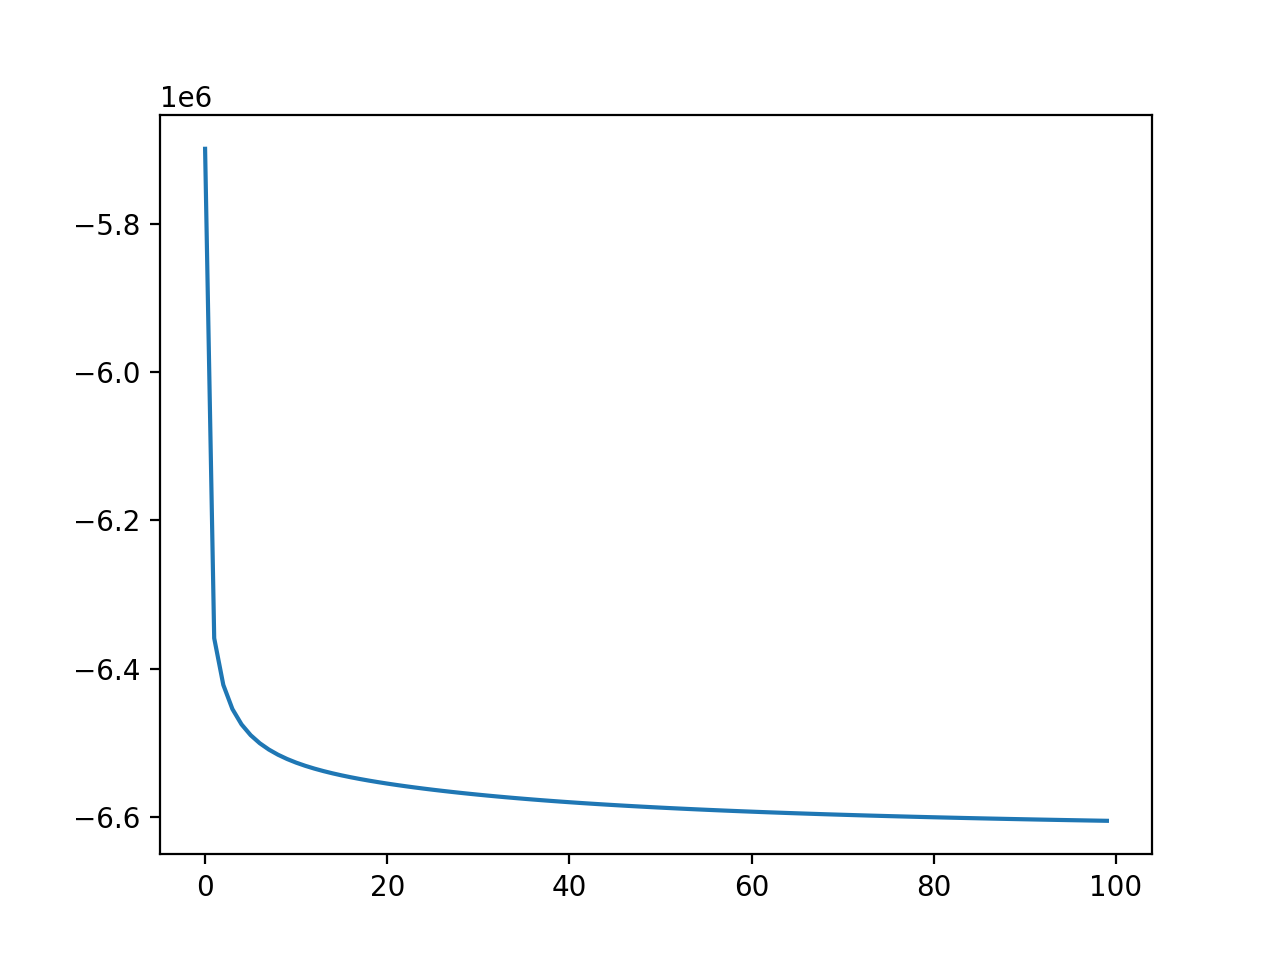

In [122]:
model_dist = ACG
model = TorchMixtureModel(model_dist, K=3, dist_dim=obs_dim)

#_ = get_param(model)

Adam_optimizer = optim.Adam(model.parameters(), lr=0.8)

epoch_likelihood = train_mixture_subjects(model, data=bold_data, optimizer=Adam_optimizer, num_epoch=100)

_ = get_param(model)

plt.plot(epoch_likelihood)
plt.show()

In [125]:
epoch_likelihood

array([-5699293.5, -6358720.5, -6421632. , -6454204. , -6474850. ,
       -6489356. , -6500234.5, -6508771. , -6515702.5, -6521484. ,
       -6526413.5, -6530686. , -6534450.5, -6537806. , -6540830.5,
       -6543589. , -6546118.5, -6548461.5, -6550643. , -6552690.5,
       -6554617.5, -6556442. , -6558172. , -6559822.5, -6561395. ,
       -6562902.5, -6564346. , -6565731. , -6567063.5, -6568342. ,
       -6569578. , -6570764.5, -6571909. , -6573012.5, -6574074.5,
       -6575103. , -6576090.5, -6577049. , -6577972. , -6578868.5,
       -6579728.5, -6580568.5, -6581374. , -6582159.5, -6582917.5,
       -6583651.5, -6584362.5, -6585055. , -6585725. , -6586376. ,
       -6587008. , -6587624.5, -6588218. , -6588799.5, -6589364.5,
       -6589915. , -6590446.5, -6590970.5, -6591476.5, -6591970. ,
       -6592448.5, -6592919. , -6593377. , -6593821.5, -6594256.5,
       -6594679.5, -6595096.5, -6595501. , -6595898. , -6596284. ,
       -6596656.5, -6597025.5, -6597388.5, -6597742. , -659808

### Evaluate Number of Clusters Watson

In [ ]:
clusters = list(range(4,15))
print(clusters)

### Evaluate NUmber of clusters ACG

### Compare Watson and ACG on optimal cluster

# Hidden Markov modelling 